In [53]:
import os
import librosa
import pandas as pd
import numpy as np
import json
import torch
import torchaudio
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import Audio
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2ForSequenceClassification
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

import umap.umap_ as umap
import matplotlib.pyplot as plt

from functions import AudioMNISTDataset, create_dataloaders, collate_fn

from scipy.spatial.distance import pdist, squareform

from scipy.spatial.distance import cdist

import time

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
def plot_umap(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Ensure 'features' is a numpy array
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

def forward_pass(model, dataloader):
    with torch.no_grad():
        all_labels = []
        for batch in dataloader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)
    
            # Forward pass
            outputs = model(input_values)
            all_labels.append(labels.cpu())
    return all_labels

def hook(module, input, output):
    # Apply mean pooling over the sequence length dimension (dim=1)
    pooled_output = output[1].mean(dim=1)  # Shape: [batch_size, 768]
    projector_features.append(pooled_output.detach())
    
def register_hook(layer):
    """
    Registers a forward hook to store features in the dynamically provided storage.

    Args:
        layer (nn.Module): The layer to which the hook should be attached.
        feature_storage (list): A mutable list to store the features extracted by the hook.
    
    Returns:
        hook_handle (torch.utils.hooks.RemovableHandle): Handle to manage the hook lifecycle.
    """
    feature_storage = []
    def hook(module, input, output):
        
        if isinstance(output, tuple):
            if isinstance(output[0], torch.Tensor):
                output = output[0]
            elif isinstance(output[1], torch.Tensor):
                output = output[1]
            elif isinstance(output[2], torch.Tensor):
                output = output[3]
        #elif isinstance(output, tuple):
        #    print("ok")
        else:
            raise ValueError('Bad format')
        
        #elif isinstance(output, torch.Tensor):
            # do nothing - output is correct

        # Apply mean pooling over the sequence length dimension (dim=1)
        pooled_output = output.mean(dim=1)  # Shape: [batch_size, 768]
        feature_storage.append(pooled_output.detach())  # Append the pooled output to the passed storage

    # Register the hook
    hook_handle = layer.register_forward_hook(hook)
    return hook_handle, feature_storage

In [3]:
# Reload the processor (optional but useful if needed for inference)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

dataloaders = create_dataloaders("AudioMNIST/data/", processor, batch_size=16)

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

In [33]:
# Load saved model
model1 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model1.load_state_dict(torch.load("seq-class-head.pth", weights_only=True))
model1.to(device)
model1.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [4]:
# Load saved model
model2 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model2.load_state_dict(torch.load("seq-class-fine.pth", weights_only=True))
model2.to(device)
model2.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


### UMAP of model1 (only class head)

In [ ]:
#projector_hook, projector_features = register_hook(model1.projector)
#feat_hook, feature_projection_features = register_hook(model1.wav2vec2.feature_projection)
hook1, hook1_s = register_hook(model1.wav2vec2.encoder.layers[0].attention)
hook2, hook2_s = register_hook(model1.wav2vec2.encoder.layers[1].attention)
hook3, hook3_s = register_hook(model1.wav2vec2.encoder.layers[2].attention)
hook4, hook4_s = register_hook(model1.wav2vec2.encoder.layers[3].attention)
hook5, hook5_s = register_hook(model1.wav2vec2.encoder.layers[4].attention)
hook6, hook6_s = register_hook(model1.wav2vec2.encoder.layers[5].attention)
hook7, hook7_s = register_hook(model1.wav2vec2.encoder.layers[6].attention)
hook8, hook8_s = register_hook(model1.wav2vec2.encoder.layers[7].attention)
hook9, hook9_s = register_hook(model1.wav2vec2.encoder.layers[8].attention)
hook10, hook10_s = register_hook(model1.wav2vec2.encoder.layers[9].attention)
hook11, hook11_s = register_hook(model1.wav2vec2.encoder.layers[10].attention)
hook12, hook12_s = register_hook(model1.wav2vec2.encoder.layers[11].attention)

all_labels = forward_pass(model1, test_loader)

# Remove the hook after extraction
#projector_hook.remove()
#feat_hook.remove()
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()
hook7.remove()
hook8.remove()
hook9.remove()
hook10.remove()
hook11.remove()
hook12.remove()

# Stack the collected features and labels
#projector_features = torch.cat(projector_features, dim=0)
#feat_hook_features = torch.cat(feature_projection_features, dim=0)
hook1_s = torch.cat(hook1_s, dim=0)
hook2_s = torch.cat(hook2_s, dim=0)
hook3_s = torch.cat(hook3_s, dim=0)
hook4_s = torch.cat(hook4_s, dim=0)
hook5_s = torch.cat(hook5_s, dim=0)
hook6_s = torch.cat(hook6_s, dim=0)
hook7_s = torch.cat(hook7_s, dim=0)
hook8_s = torch.cat(hook8_s, dim=0)
hook9_s = torch.cat(hook9_s, dim=0)
hook10_s = torch.cat(hook10_s, dim=0)
hook11_s = torch.cat(hook11_s, dim=0)
hook12_s = torch.cat(hook12_s, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy for UMAP
#projector_features_np = projector_features.cpu().numpy()
#feat_hook_features_np = feat_hook_features.cpu().numpy()
hook1_n = hook1_s.cpu().numpy()
hook2_n = hook2_s.cpu().numpy()
hook3_n = hook3_s.cpu().numpy()
hook4_n = hook4_s.cpu().numpy()
hook5_n = hook5_s.cpu().numpy()
hook6_n = hook6_s.cpu().numpy()
hook7_n = hook7_s.cpu().numpy()
hook8_n = hook8_s.cpu().numpy()
hook9_n = hook9_s.cpu().numpy()
hook10_n = hook10_s.cpu().numpy()
hook11_n = hook11_s.cpu().numpy()
hook12_n = hook12_s.cpu().numpy()
labels_np = all_labels.cpu().numpy()

--- 0.13879704475402832 seconds ---


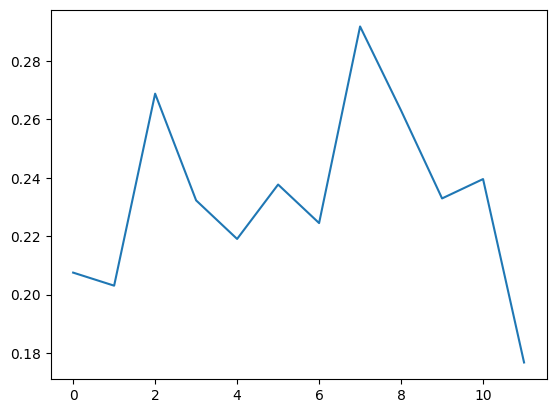

In [82]:
s_time = time.time()
hookn = [hook1_n, hook2_n, hook3_n, hook4_n, hook5_n, hook6_n, hook7_n, hook8_n, hook9_n, hook10_n, hook11_n, hook12_n]
scores = []
for h in hookn:
    temp_mean, dp = discriminant_power(h, labels_np)
    scores.append(temp_mean)
print("--- %s seconds ---" % (time.time() - s_time))
plt.plot(scores)
plt.show()

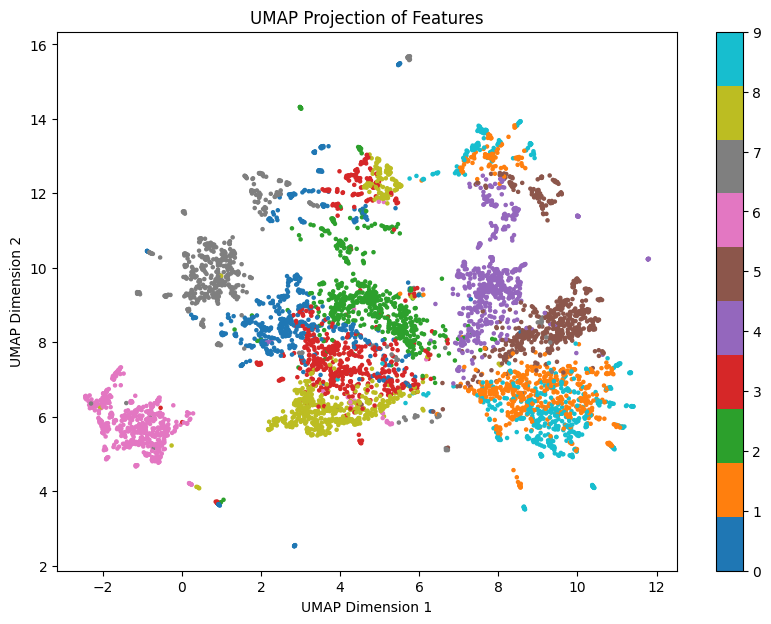

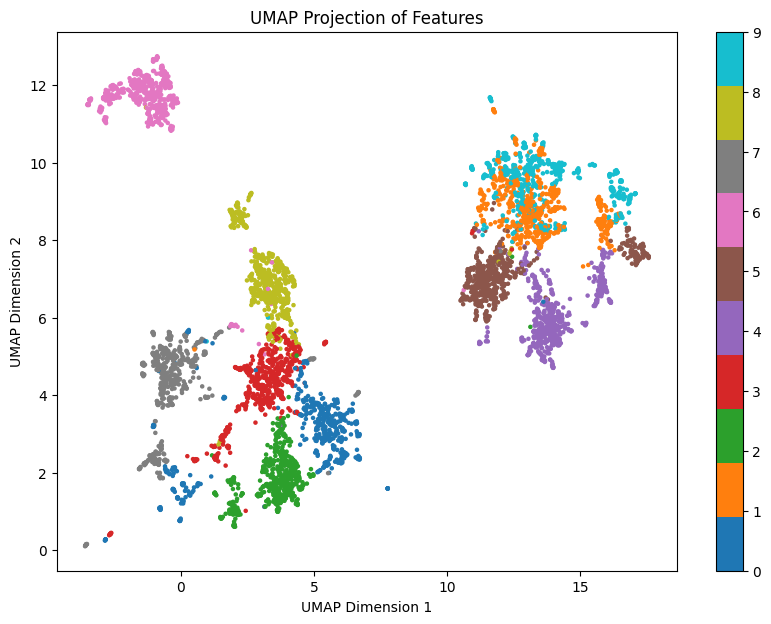

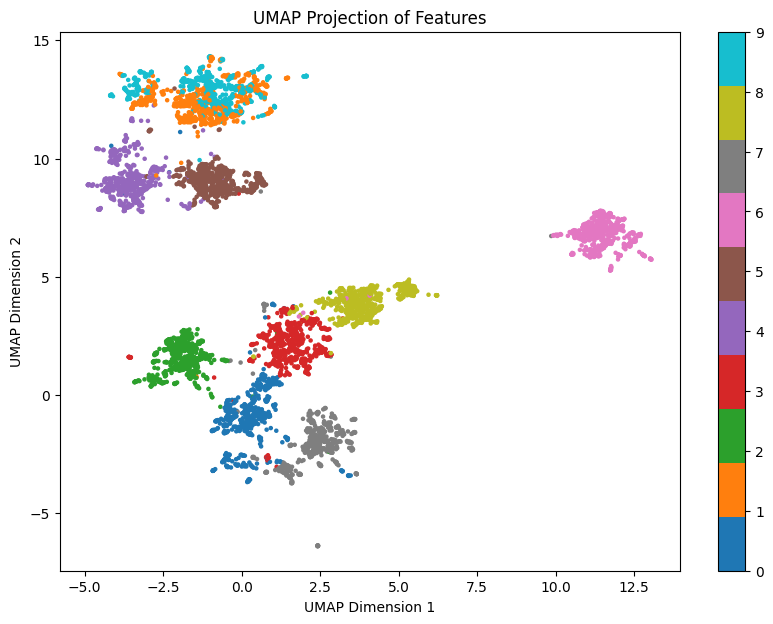

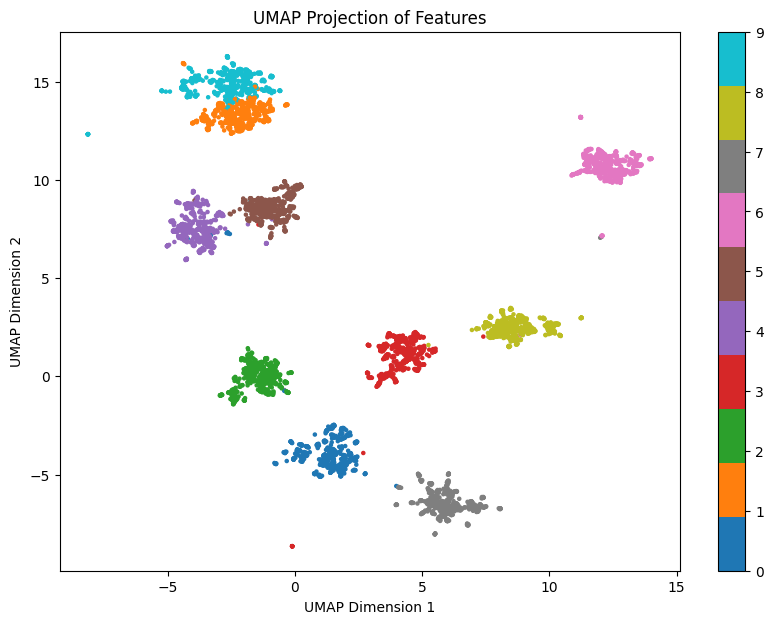

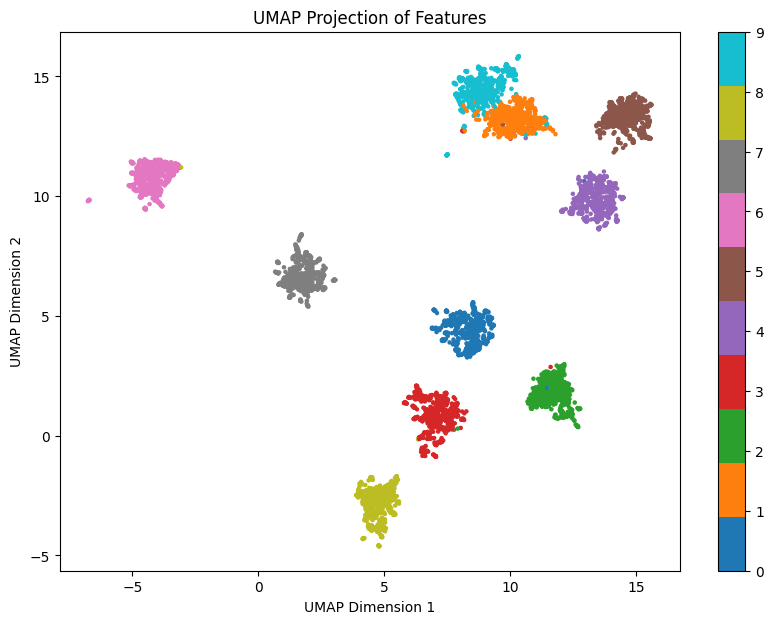

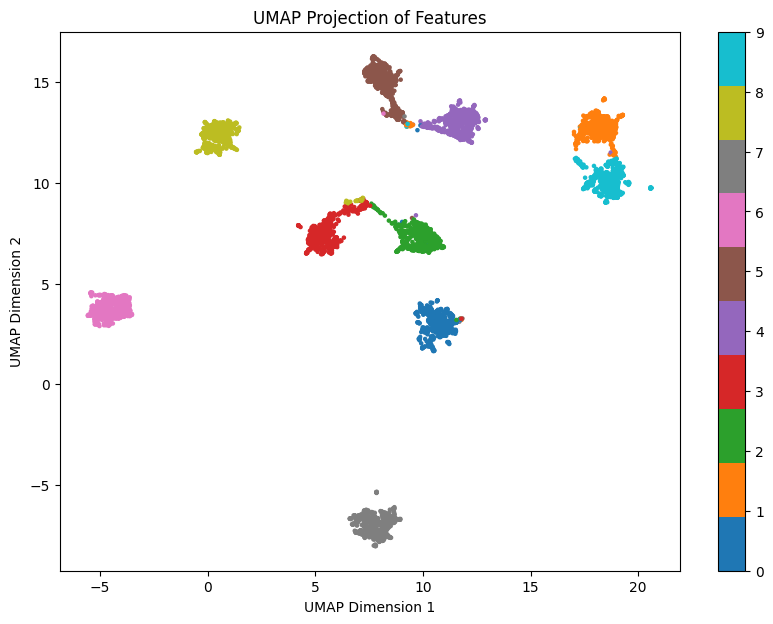

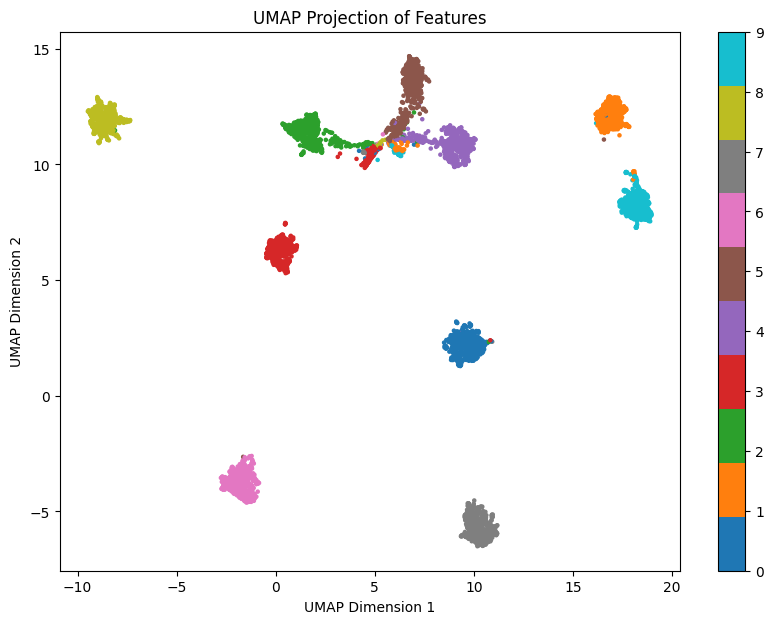

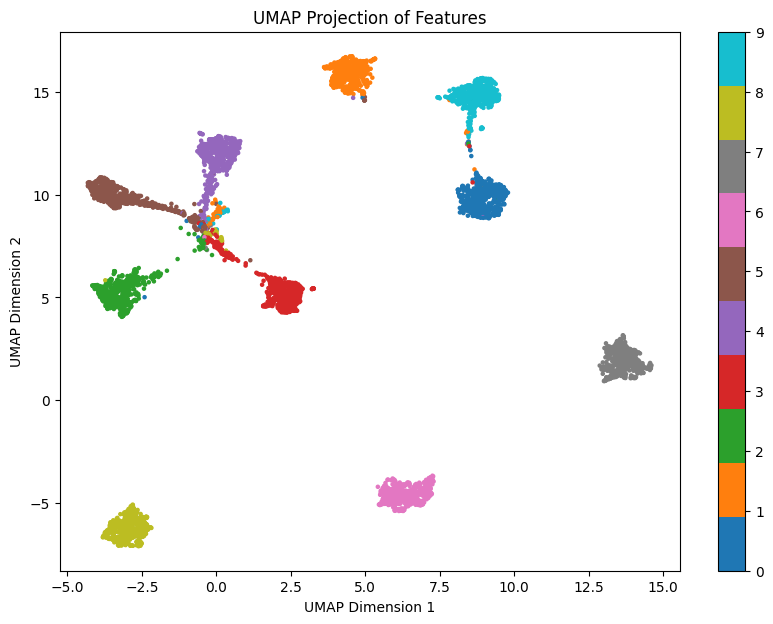

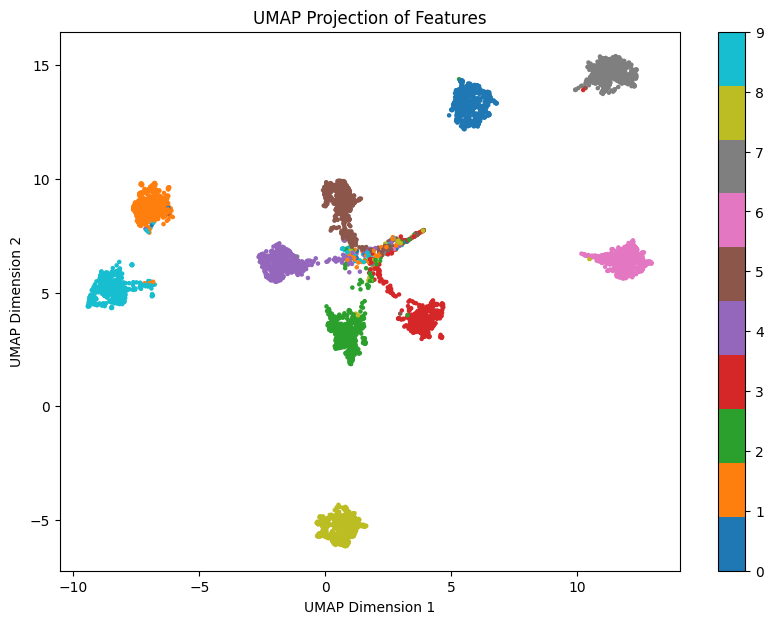

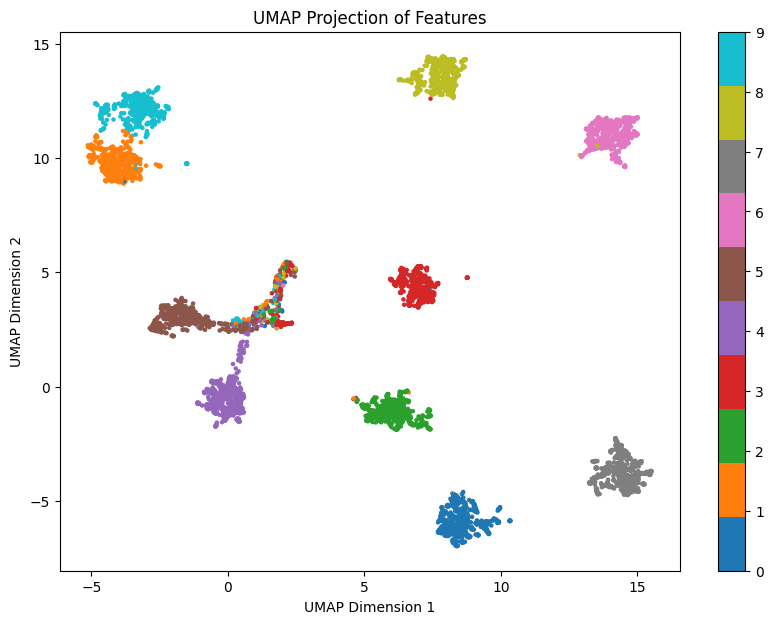

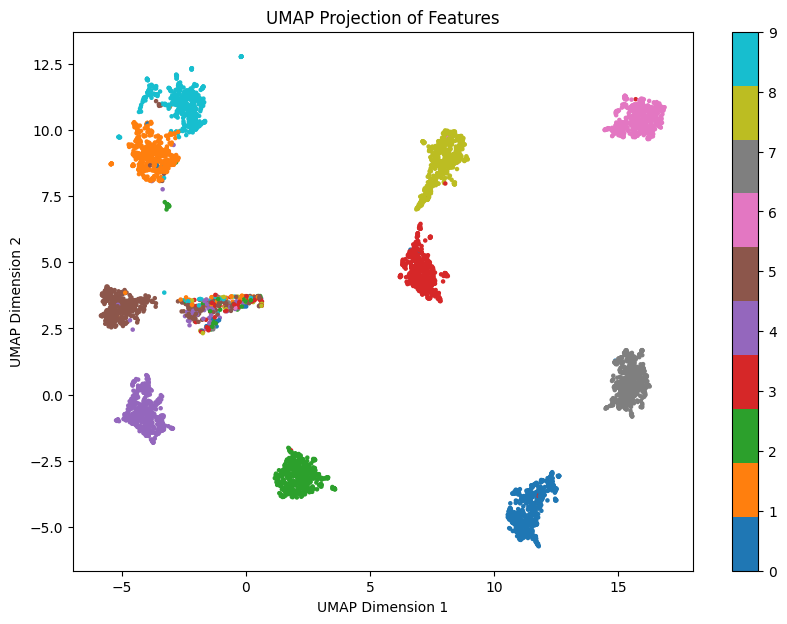

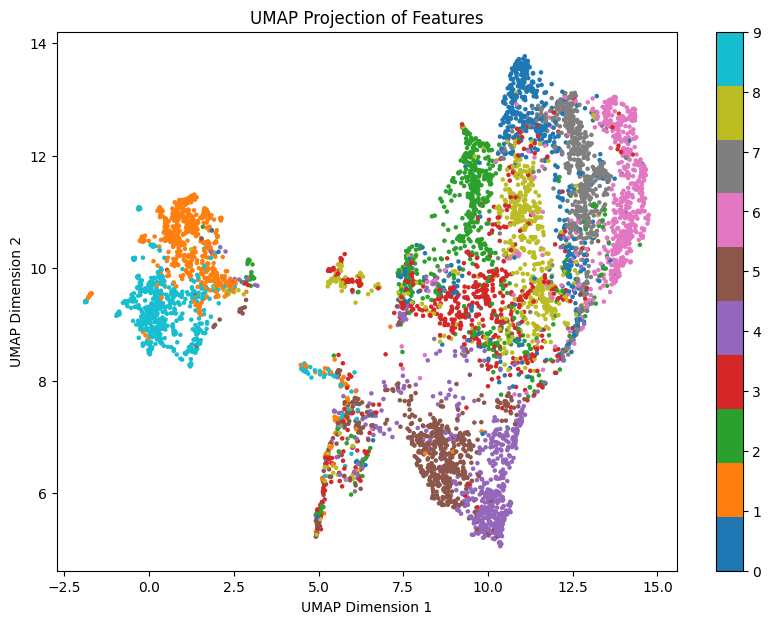

In [72]:
for h in hookn:
    plot_umap(h, labels_np)

0.5549628751879437


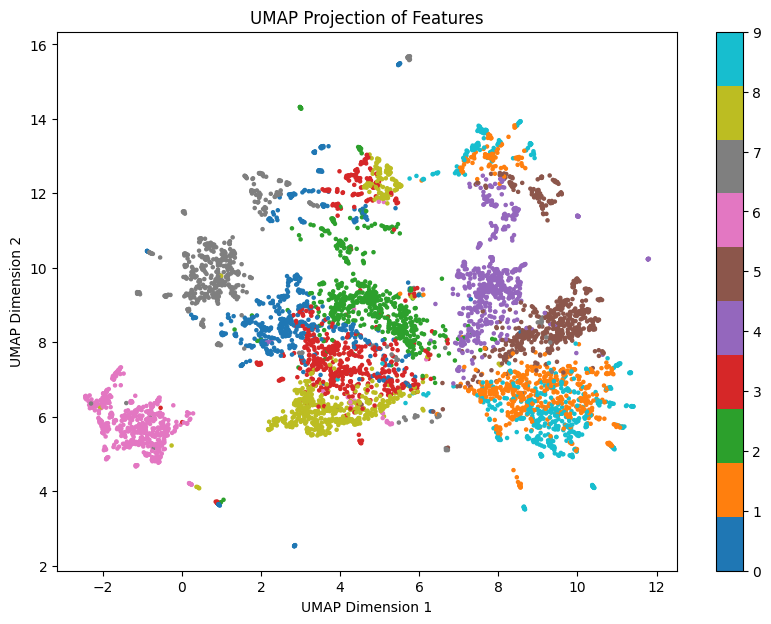

--- 9.118953466415405 seconds ---


In [57]:
print(clustering_score(hook11_n, labels_np))

start_time = time.time()
plot_umap(hook1_n, labels_np)
print("--- %s seconds ---" % (time.time() - start_time))
#plot_umap(feat_hook_features_np, labels_np)

### UMAP of model2 (fine-tuned)

In [6]:
#ph2, pf2 = register_hook(model2.projector)
#fh2, fpf2 = register_hook(model2.wav2vec2.feature_projection)
hook1, hook1_s = register_hook(model2.wav2vec2.encoder.layers[0].attention)
hook2, hook2_s = register_hook(model2.wav2vec2.encoder.layers[1].attention)
hook3, hook3_s = register_hook(model2.wav2vec2.encoder.layers[2].attention)
hook4, hook4_s = register_hook(model2.wav2vec2.encoder.layers[3].attention)
hook5, hook5_s = register_hook(model2.wav2vec2.encoder.layers[4].attention)

all_labels = forward_pass(model2, test_loader)

# Remove the hook after extraction
#ph2.remove()
#fh2.remove()
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()

# Stack the collected features and labels
hook1_s = torch.cat(hook1_s, dim=0)
hook2_s = torch.cat(hook2_s, dim=0)
hook3_s = torch.cat(hook3_s, dim=0)
hook4_s = torch.cat(hook4_s, dim=0)
hook5_s = torch.cat(hook5_s, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy for UMAP
hook1_n = hook1_s.cpu().numpy()
hook2_n = hook2_s.cpu().numpy()
hook3_n = hook3_s.cpu().numpy()
hook4_n = hook4_s.cpu().numpy()
hook5_n = hook5_s.cpu().numpy()
labels_np = all_labels.cpu().numpy()

In [13]:
hook5_n.shape

(6000, 768)

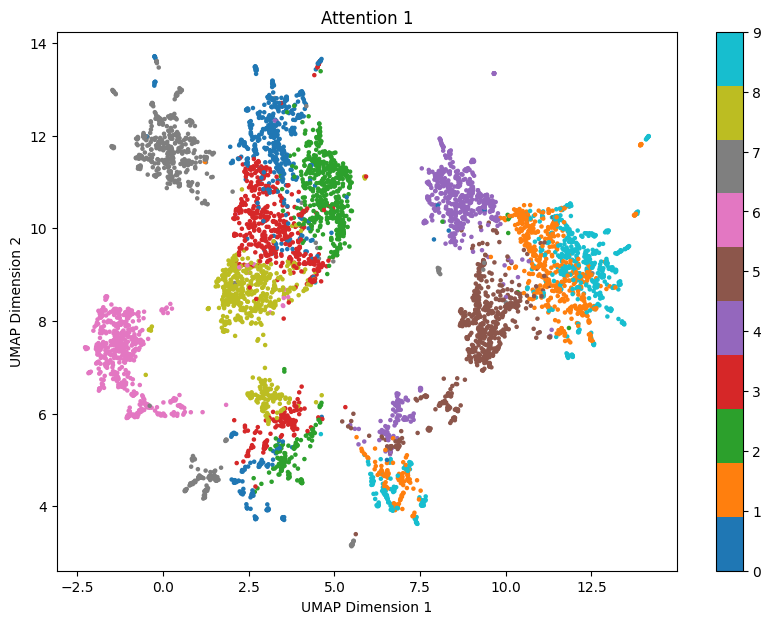

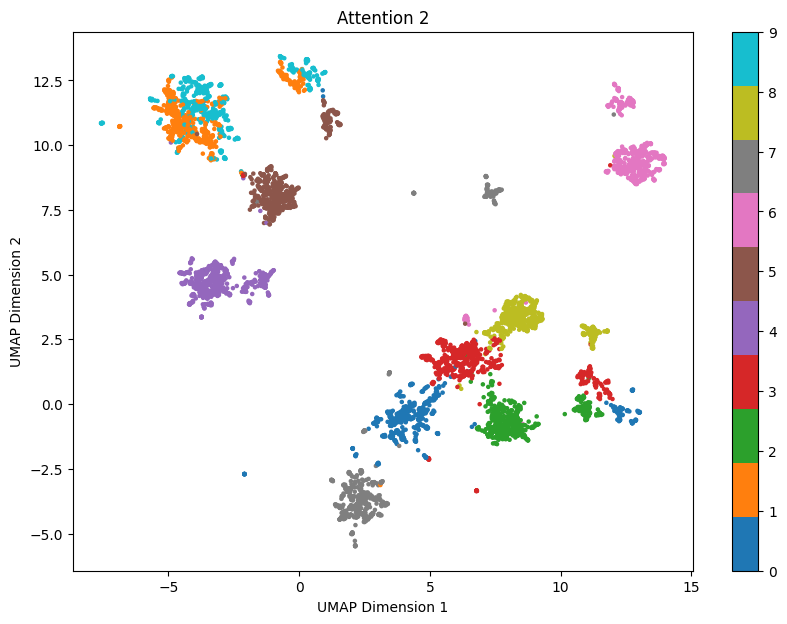

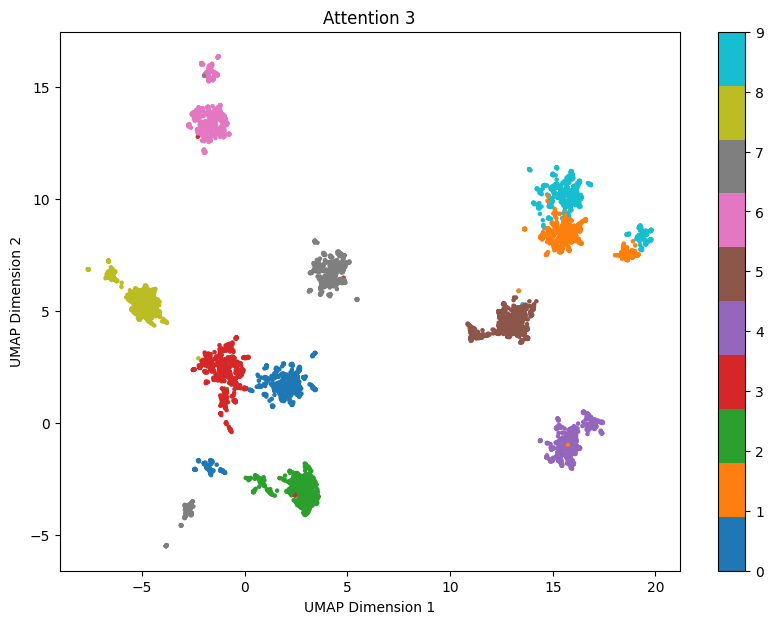

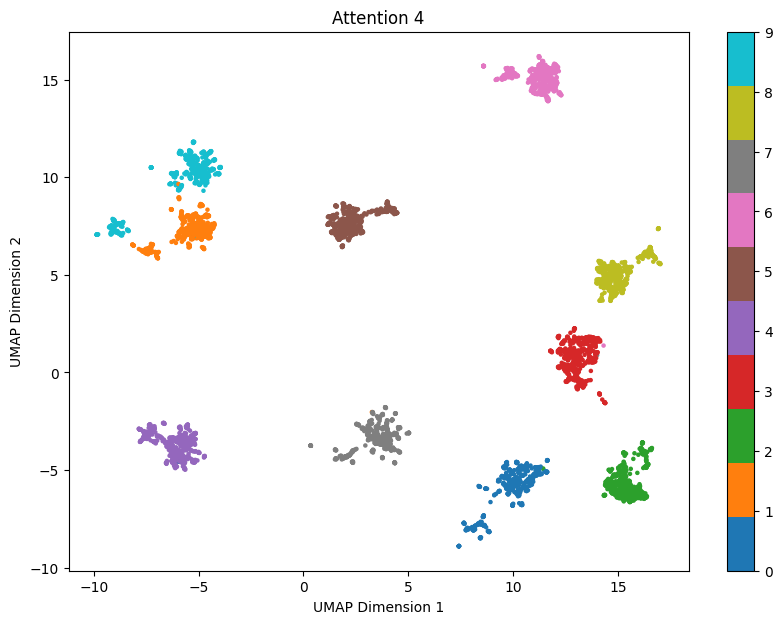

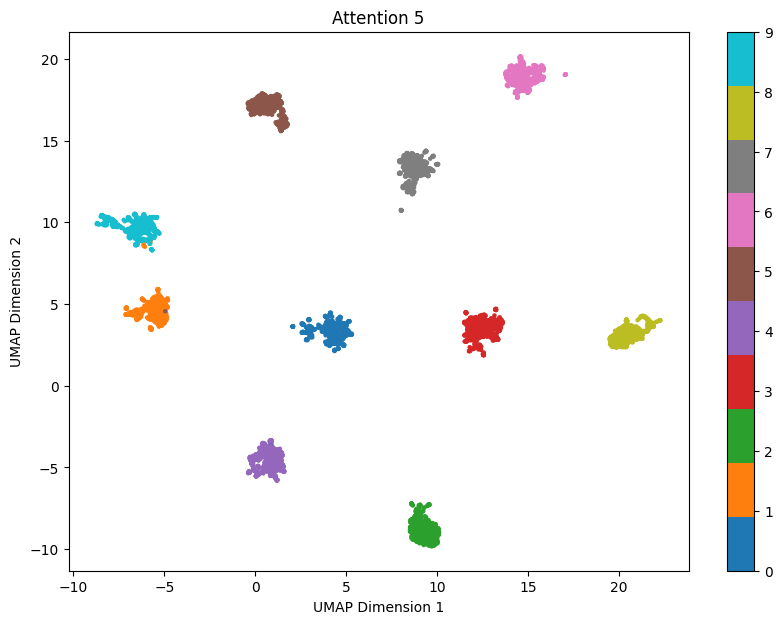

In [10]:
plot_umap(hook1_n, labels_np, title="Attention 1")
plot_umap(hook2_n, labels_np, title="Attention 2")
plot_umap(hook3_n, labels_np, title="Attention 3")
plot_umap(hook4_n, labels_np, title="Attention 4")
plot_umap(hook5_n, labels_np, title="Attention 5")

In [22]:
def fisher_linear_discriminant(data, classes):
    """
    Fisher's Linear Discriminant for k classes.
    
    Args:
        data (np.ndarray): Shape (6000, 768), feature vectors.
        classes (np.ndarray): Shape (6000,), class labels (0, 1, ..., k-1).
    
    Returns:
        np.ndarray: Projection matrix of shape (768, k-1).
    """
    # Unique classes and overall mean
    class_labels = np.unique(classes)
    k = len(class_labels)  # Number of classes
    n_features = data.shape[1]  # Feature dimensionality
    overall_mean = np.mean(data, axis=0)

    # Compute within-class scatter matrix S_W and between-class scatter matrix S_B
    S_W = np.zeros((n_features, n_features))
    S_B = np.zeros((n_features, n_features))
    
    for label in class_labels:
        class_data = data[classes == label]
        class_mean = np.mean(class_data, axis=0)
        
        # Within-class scatter
        S_W += np.cov(class_data, rowvar=False) * (class_data.shape[0] - 1)
        
        # Between-class scatter
        n_c = class_data.shape[0]  # Number of samples in the class
        mean_diff = (class_mean - overall_mean).reshape(-1, 1)
        S_B += n_c * (mean_diff @ mean_diff.T)

    # Solve the generalized eigenvalue problem for S_W^-1 S_B
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(-eigvals.real)  # Descending order
    eigvecs = eigvecs[:, sorted_indices]
    
    # Select top k-1 eigenvectors
    W = eigvecs[:, :k-1].real  # Projection matrix of shape (768, k-1)
    
    return W

# Example usage
W = fisher_linear_discriminant(hook5_n, labels_np)

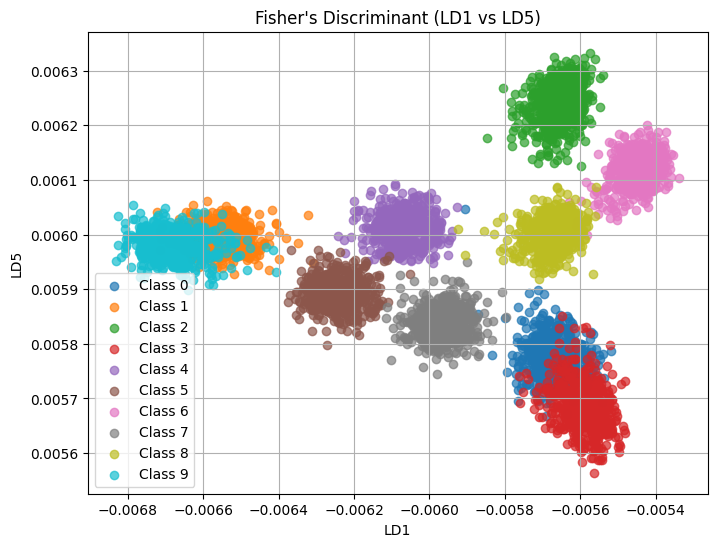

In [27]:
def plot_pairwise_2d(data, classes, W, dim1=0, dim2=1):
    """
    Pairwise 2D plot for projected data.
    
    Args:
        data (np.ndarray): Original data of shape (6000, 768).
        classes (np.ndarray): Class labels of shape (6000,).
        W (np.ndarray): Projection matrix of shape (768, k-1).
        dim1 (int): Index of the first dimension to plot.
        dim2 (int): Index of the second dimension to plot.
    """
    # Project data
    projected_data = data @ W  # Shape (6000, 9 for 10 classes)
    
    plt.figure(figsize=(8, 6))
    for label in np.unique(classes):
        plt.scatter(projected_data[classes == label, dim1],
                    projected_data[classes == label, dim2],
                    label=f'Class {label}', alpha=0.7)
    plt.title(f'Fisher\'s Discriminant (LD{dim1 + 1} vs LD{dim2 + 1})')
    plt.xlabel(f'LD{dim1 + 1}')
    plt.ylabel(f'LD{dim2 + 1}')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
plot_pairwise_2d(hook5_n, labels_np, W, dim1=0, dim2=4)

In [51]:
def normalized_clustering_score(labels, data):
    """
    Compute a normalized clustering score adjusted for feature dimensionality.
    
    Parameters:
        labels (array-like): 1D array of cluster labels for each data point.
        data (ndarray): 2D array of shape (n_samples, n_features).
        
    Returns:
        float: Normalized clustering quality score.
    """
    # Ensure data is in (n_samples, n_features) format
    data = np.array(data)
    labels = np.array(labels)
    
    # Validate shapes
    if data.shape[0] != len(labels):
        raise ValueError(f"Mismatch: data has {data.shape[0]} samples, but labels have {len(labels)} elements.")
    
    # Get dimensions
    n_samples, n_features = data.shape
    normalization_factor = np.sqrt(n_features)
    
    # Get unique clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters < 2:
        raise ValueError("Clustering score requires at least two clusters.")
    
    # Compute intra-cluster compactness
    intra_distances = []
    centroids = []
    
    for label in unique_labels:
        cluster_points = data[labels == label]  # Correct indexing
        if len(cluster_points) < 2:
            continue
        # Mean intra-cluster distance
        pairwise_distances = cdist(cluster_points, cluster_points, metric='euclidean')
        mean_intra_distance = np.sum(pairwise_distances) / (len(cluster_points) * (len(cluster_points) - 1))
        intra_distances.append(mean_intra_distance)
        centroids.append(cluster_points.mean(axis=0))
    
    # Compute inter-cluster separation
    centroids = np.array(centroids)
    inter_distances = cdist(centroids, centroids, metric='euclidean')
    mean_inter_distance = np.mean(inter_distances[np.triu_indices_from(inter_distances, k=1)])
    
    # Normalize distances by sqrt of number of features
    mean_intra_distance = np.mean(intra_distances) / normalization_factor
    mean_inter_distance = mean_inter_distance / normalization_factor
    
    # Compute final score
    score = mean_inter_distance / mean_intra_distance
    return score

clustering_score(hook5_n, labels_np)

0.8314817015728605

In [52]:
test = np.array([[1,1],[0.9,1],[1.1,1],[5,5],[5,5.1],[5,4.9]])
test_labels = np.array([0,0,0,1,1,1])
clustering_score(test,test_labels)

42.42640687119292

In [83]:
start_time = time.time()
distances = squareform(pdist(hook5_n, metric='euclidean'))
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.054000854492188 seconds ---


In [81]:
def discriminant_power(features, labels):
    """
    Computes the normalized Discriminant Power (DP) for clustering evaluation.
    
    Parameters:
    - labels (array-like): Cluster labels for each data point (shape: [n_samples]).
    - features (ndarray): Feature matrix (shape: [n_samples, n_features]).
    
    Returns:
    - float: The overall normalized Discriminant Power (scaled between 0 and 1).
    - ndarray: Normalized Discriminant Power for each feature (shape: [n_features], scaled between 0 and 1).
    """
    # Ensure labels and features have compatible dimensions
    n_samples, n_features = features.shape
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters < 2:
        raise ValueError("Discriminant Power requires at least two clusters.")
    
    # Compute the global mean for each feature
    global_mean = np.mean(features, axis=0)  # Shape: [n_features]
    
    # Initialize between-cluster and within-cluster variance
    between_variance = np.zeros(n_features)  # Shape: [n_features]
    within_variance = np.zeros(n_features)  # Shape: [n_features]
    
    # Compute variances for each cluster
    for label in unique_labels:
        cluster_data = features[labels == label]
        cluster_mean = np.mean(cluster_data, axis=0)  # Mean of the cluster
        cluster_size = cluster_data.shape[0]  # Number of points in the cluster
        
        # Between-cluster variance
        between_variance += cluster_size * (cluster_mean - global_mean) ** 2
        
        # Within-cluster variance
        within_variance += np.sum((cluster_data - cluster_mean) ** 2, axis=0)
    
    # Normalize by degrees of freedom
    between_variance /= (n_clusters - 1)
    within_variance /= (n_samples - n_clusters)
    
    # Compute Discriminant Power (avoid division by zero)
    dp = between_variance / (within_variance + 1e-10)
    
    # Normalize DP values to the range [0, 1]
    min_dp = np.min(dp)
    max_dp = np.max(dp)
    normalized_dp = (dp - min_dp) / (max_dp - min_dp + 1e-10)
    
    # Return overall normalized DP (mean across features) and per-feature normalized DP
    return np.mean(normalized_dp), normalized_dp